In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_model_type_name(row,columns):
    strings = [str(row[col]) for col in columns if pd.notna(row[col])]
    return '-'.join(strings)

In [3]:
df_results = pd.read_csv("../Results/InvestmentModelResults/Loop_4models_indirect_neighbors_v2_8760.csv")

In [4]:
#Export revenues and congestion rents should be dealt with with opposite signs
neg_components = ["cong_rent_e","export_rev"]
df_results[neg_components] = -df_results[neg_components]

#Split congestion rents equally between neighbors
rents = ['cong_rent_i', 'cong_rent_e']
df_results[rents] = df_results[rents]/2

#Combine operational cost components 
operational_costs = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost']
df_results["Operational costs"] = df_results[operational_costs].sum(axis=1)

cost_vals = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost','investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total cost"] = df_results[cost_vals].sum(axis=1)

trade_cost_vals = ['export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total trade cost"] = df_results[trade_cost_vals].sum(axis=1)

#Add net import 
df_results["Net import"] = df_results["imported"] - df_results["exported"]

#Add load shedding 
df_results["Load shedding"] = df_results["load_shedding_cost"]/8000

#Add total production
df_results["Total production"] = df_results["w_off_prod"]+ df_results["w_on_prod"]+ df_results["PV_prod"]+df_results["CCGT_prod"]+df_results["OCGT_prod"]

In [5]:
# Assuming df is your DataFrame
new_column_names = {
    'CY': 'CY',
    'CY_ts': 'CY_ts',
    'VOLL': 'VOLL',
    'type': 'type',
    'simplified': 'simplified',
    'investment_cost': 'investment cost',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'PV': 'PV',
    'w_on': 'w_on',
    'w_off': 'w_off',
    'CCGT_prod': 'CCGT prod',
    'OCGT_prod': 'OCGT prod',
    'PV_prod': 'PV prod',
    'w_on_prod': 'w_on prod',
    'w_off_prod': 'w_off prod',
    'imported': 'imported',
    'exported': 'exported',
    'import_cost': 'import cost',
    'export_rev': 'export revenue',
    'cong_rent_i': 'congestion rent import',
    'cong_rent_e': 'congestion rent export',
    'demand': 'demand',
    'peak_demand': 'peak demand',
    'nb_techs_neighbours': 'nb techs neighbours',
    'time_solve': 'time solve',
    'time_build': 'time build',
    'time_TC': 'time TC',
    'Operational costs': 'Operational costs',
    'Total cost': 'Total cost',
    'Net import': 'Net import',
    'Load shedding': 'Load shedding',
    'Total production': 'Total production',
    'name': 'name',
    'Model Type': 'Model Type'
}

df_results.rename(columns=new_column_names, inplace=True)

In [6]:
geo_scope_map = {
    'A_l_l': 'All',
    'DE00_NL00_FR00_UK00_BE00': 'DN',
    'N_A': ''
}
df_results["geoscope_m"] = df_results["geoscope"].replace(geo_scope_map)

# List of columns to consider for joining
columns_to_join = ['type', 'trans_cap_other', 'geoscope_m']

# Apply the function row-wise to create the new column
df_results['name'] = df_results.apply(create_model_type_name, args=(columns_to_join,), axis=1)

name_map = {
    'NTC-1.0e10-DN': 'SN-DN',
    'NTC-1.0e10-All': 'SN-All',
    'NTC-S-All': "NTC-All",
    'NTC-S-DN': "NTC-DN",
    'TCPC-All': "TCPC-All",
    'TCPC-DN': "TCPC",
    
}
df_results['Model Type'] = df_results["name"].replace(name_map)


In [7]:
# Get deviations from benchmark model
bm_t = "NTC-DN"

# Filter the DataFrame for the benchmark model
col_bm = df_results[(df_results["Model Type"] == bm_t)]

# Initialize an empty list to store deviations
dev_data = []

vals_dev = ["CCGT", "OCGT", "PV", "w_off", "w_on"]

# Calculate deviations from the benchmark model
for index, row in df_results.iterrows():
    t = row["type"]
    stepsize = row["stepsize"]
    trans_cap_other = row["trans_cap_other"]
    model_type = row["Model Type"]
    deviations = row[vals_dev] - col_bm.iloc[0][vals_dev]# Accessing the first row of col_bm for deviations
    perc_deviations = (row[vals_dev] - col_bm.iloc[0][vals_dev])/col_bm.iloc[0][vals_dev]
    
    # Create a dictionary for the deviations
    dev_dict = {"Model Type":model_type,"type": t, "stepsize": stepsize, "trans_cap_other": trans_cap_other}
    for col, dev,per_dev in zip(vals_dev, deviations,perc_deviations):
        dev_dict[col] = dev
        dev_dict[col+"_dev"] = per_dev
    
    # Append the dictionary to the list
    dev_data.append(dev_dict)

# Create DataFrame from the list of dictionaries
dev_df = pd.DataFrame(dev_data)

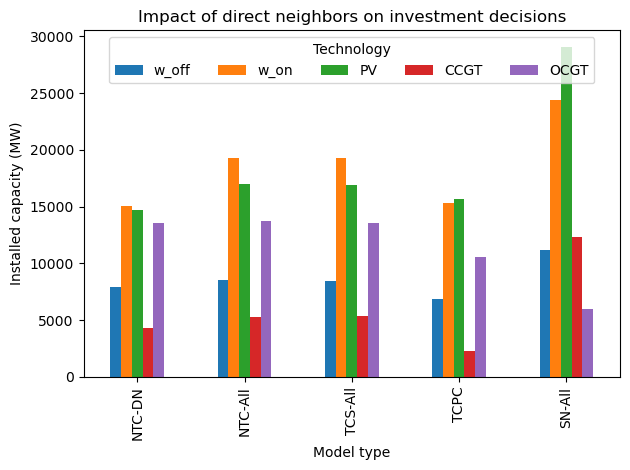

In [11]:
## Plot installed capacities 

# Define the types to include and order in which you want the types to appear
type_order = ["NTC-DN", "NTC-All", "TCS-All","TCPC","SN-All"]
filter_condition = df_results["Model Type"].isin(type_order)
filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()
#filtered_df = dev_df[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]
    #vals= ["CCGT_dev", "OCGT_dev","PV_dev","w_on_dev","w_off_dev"]
#vals = ["imported","exported"]


filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
if stacked: 
    #plt.ylim((0,70000))
    pass
else:
    #plt.ylim((0,30000))
    #plt.ylim((0,0.5))

    pass
    
plt.title('Impact of direct neighbors on investment decisions')
plt.tight_layout()
plt.legend(title='Technology',loc = "upper center",ncols = 5)

#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/InDirectNeighbors//Installed_capacities_bar_{stacked}_IDN.png")

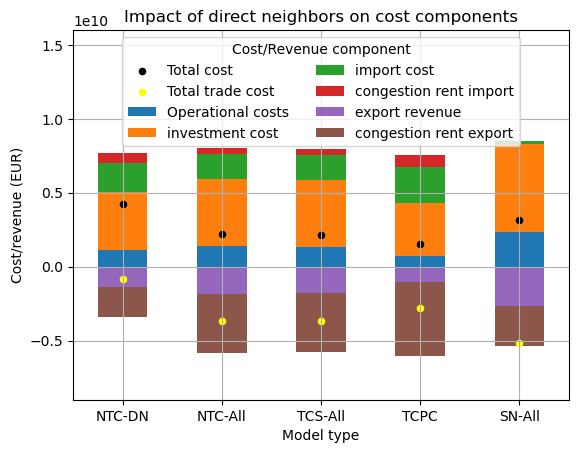

In [93]:
## Plot cost components 

# Define the types to include and order in which you want the types to appear
type_order = ["NTC-DN", "NTC-All", "TCS-All","TCPC","SN-All"]
filter_condition = df_results["Model Type"].isin(type_order)
filtered_df = filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()


fig, ax = plt.subplots(1)

vals = ["Operational costs",
       'investment cost', "import cost", 'congestion rent import','export revenue', 'congestion rent export']
vals_tot = vals
#vals_tot = "Total cost"

#vals = ["imported","exported"]

stacked = True
filtered_df.plot.bar(x="Model Type", y=vals_tot, stacked=stacked,ax = ax)

# Scatter plot for multiple columns with different colors
scatter_columns = ['Total cost', 'Total trade cost']
colors = ['black', 'yellow']  # Define colors for each scatter plot

for col, color in zip(scatter_columns, colors):
    filtered_df.plot.scatter(x="Model Type", y=col, ax=ax, label=col, color=color)
# filtered_df.plot.scatter(x="Model Type", y=["Total cost","Total cost"],ax = ax)
# filtered_df.plot.scatter(x="Model Type", y="Total trade cost",ax = ax,label = "Total cost")

plt.xlabel('Model type')
plt.ylabel('Cost/revenue (EUR)')
plt.title('Impact of direct neighbors on cost components')
plt.legend(title='Cost/Revenue component',ncols = 2,loc = "upper center")
if stacked: 
    plt.ylim((-9e9,16e9))    
else: 
    plt.ylim((-6e9,12e9))
plt.grid(True)  # Adding grid


#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/InDirectNeighbors/Cost_components_bar_s{stacked}_IDN.png")